**Computation of wasserstein barycenters**

The Wasserstein barycenter problem attempts to summarize a collection $(\mu_i){_{i=1,...,n}}$ of probability distributions by taking their weighted average with respect to the Wasserstein distance. Following [Agueh and Carlier 2011], given a set of weights $\alpha = (\alpha_i){_{i=1,...,n}}$, it is defined as the following problem : 
\begin{equation}
\min_{\mu} \sum_{i=1}^{k} \alpha_i W_2^2(\mu, \mu_i)
\end{equation}

In [21]:
import numpy as np
import matplotlib.pylab as pl
import torch
import ot
import matplotlib.animation as animation

In [22]:
def preprocess_image(image_path, new_size = (256, 256)):
    image = Image.open(image_path).convert('L')
    image = image.resize(new_size)
    image = image / np.sum(image)  # Normalisation pour que la somme des pixels = 1 (ie l'image est une distribution)
    return image

**Wasserstein barycenter**

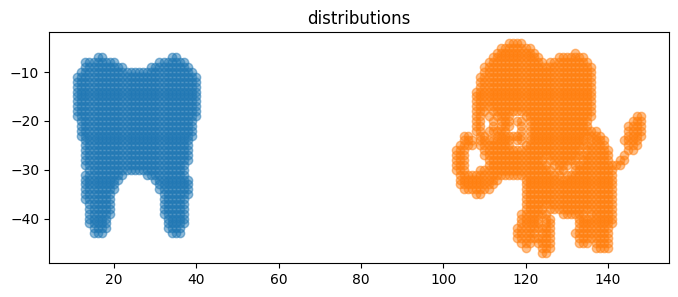

In [23]:
import numpy as np
import matplotlib.pylab as pl
import torch
import ot
import matplotlib.animation as animation
from PIL import Image 

I1_img = preprocess_image('data/dent.jpg')
I2_img = preprocess_image('data/elephant.jpg')
I1 = np.array(I1_img)
I2 = np.array(I2_img)

# Réduire la taille des images pour simplifier le traitement
I1 = I1[::5, ::5]
I2 = I2[::5, ::5]

I1[I1 < np.mean(I1)] = 0 #pour revenir a un vrai noir pour la dent

# Obtenir la taille des images
sz = I2.shape[0]
XX, YY = np.meshgrid(np.arange(sz), np.arange(sz))

# Extraire les coordonnées des pixels noirs
x1 = np.stack((XX[I1 == 0], -YY[I1 == 0]), 1) * 1.0
x2 = np.stack((XX[I2 == 0] + 100, -YY[I2 == 0]), 1) * 1.0
x3 = np.stack((XX[I2 == 0], -YY[I2 == 0]), 1) * 1.0

measures_locations = [x1, x2]
measures_weights = [ot.unif(x1.shape[0]), ot.unif(x2.shape[0])]

# Afficher les points extraits
pl.figure(1, (8, 3))
pl.title('distributions')
pl.scatter(x1[:, 0], x1[:, 1], alpha=0.5)
pl.scatter(x2[:, 0], x2[:, 1], alpha=0.5)
pl.show()


In [43]:
N = 2
d = 2
k = 200  # number of Diracs of the barycenter
X_init = np.random.normal(0., 1., (k, d))  # initial Dirac locations

def compute_wasserstein_barycenter(x1, x2, b, weights = [0.5, 0.5], k = 200, X_init = None):
    d = x1.shape[1]
    if X_init is None:
        X_init = np.random.normal(0., 1., (k, d))

    measures_locations = [x1, x2]
    measures_weights = [ot.unif(x1.shape[0]), ot.unif(x2.shape[0])]

    b = np.ones((k,)) / k  # weights of the barycenter (it will not be optimized, only the locations are optimized)

    X = ot.lp.free_support_barycenter(measures_locations, measures_weights, X_init, b, weights = weights)
    return(X)

b = np.ones((k,)) / k
X = compute_wasserstein_barycenter(x1, x2, b, k = 200, X_init = None)

In [61]:
ALPHA = [0.2, 0.4, 0.6, 0.8]
xb = []
for a in ALPHA:
    xb.append(compute_wasserstein_barycenter(x1, x2, b, k = 200, X_init = None, weights = [1-a, a]))

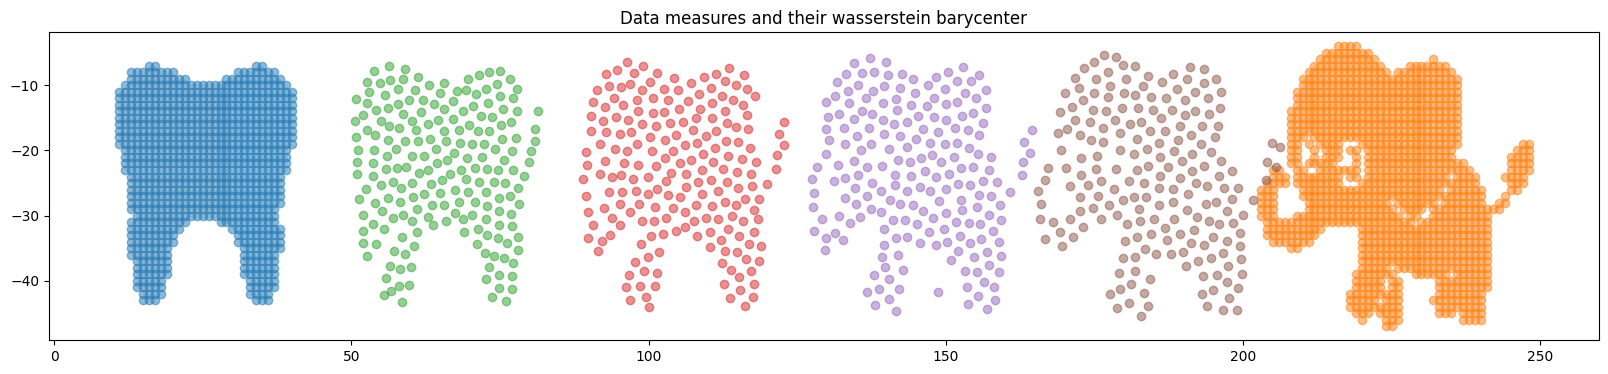

In [69]:
pl.figure(6, (20, 4))
pl.scatter(x1[:, 0], x1[:, 1], alpha=0.5)
pl.scatter(x2[:, 0]+100, x2[:, 1], alpha=0.5)
for i in range(len(xb)):
    pl.scatter(xb[i][:, 0]+20*i+20, xb[i][:, 1], alpha = 0.5, label='2-Wasserstein barycenter')
pl.title('Data measures and their wasserstein barycenter')
#pl.legend(loc="lower right")
pl.show()

**Sliced wasserstein barycenter by stochastic gardient descent algorithm**

In [28]:
def compute_sliced_wass_barycenter(x1, x3, alpha = 0.5, lr = 1e3, k = 200, d = 2, nb_iter_max = 50, xbinit = None):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    x1_torch = torch.tensor(x1).to(device=device)
    x3_torch = torch.tensor(x3).to(device=device)
    
    if xbinit is None:
        #xbinit = np.random.randn(500, 2) * 10 + 16 #initialization
        xbinit = np.random.normal(0., 1., (k, d))
    xbary_torch = torch.tensor(xbinit).to(device=device).requires_grad_(True)

    x_all = np.zeros((nb_iter_max, xbary_torch.shape[0], 2))

    loss_iter = []

    # generator for random permutations
    gen = torch.Generator(device=device)
    gen.manual_seed(42)


    for i in range(nb_iter_max):

        loss = alpha * ot.sliced_wasserstein_distance(xbary_torch, x3_torch, n_projections=50, seed=gen) \
            + (1 - alpha) * ot.sliced_wasserstein_distance(xbary_torch, x1_torch, n_projections=50, seed=gen)

        loss_iter.append(loss.clone().detach().cpu().numpy())
        loss.backward()

        # performs a step of projected gradient descent
        with torch.no_grad():
            grad = xbary_torch.grad
            xbary_torch -= grad * lr  # / (1 + i / 5e1)  # step
            xbary_torch.grad.zero_()
            x_all[i, :, :] = xbary_torch.clone().detach().cpu().numpy()

    xb = xbary_torch.clone().detach().cpu().numpy()
    return(xb)

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/var/folders/nk/rqbxbzbs6cx3djvmyg89hzhh0000gn/T/ipykernel_28087/1085290865.py:7: SyntaxWarning: invalid escape sequence '\m'
  pl.scatter(x1[:, 0], x1[:, 1], alpha=0.5, label='$\mu$')


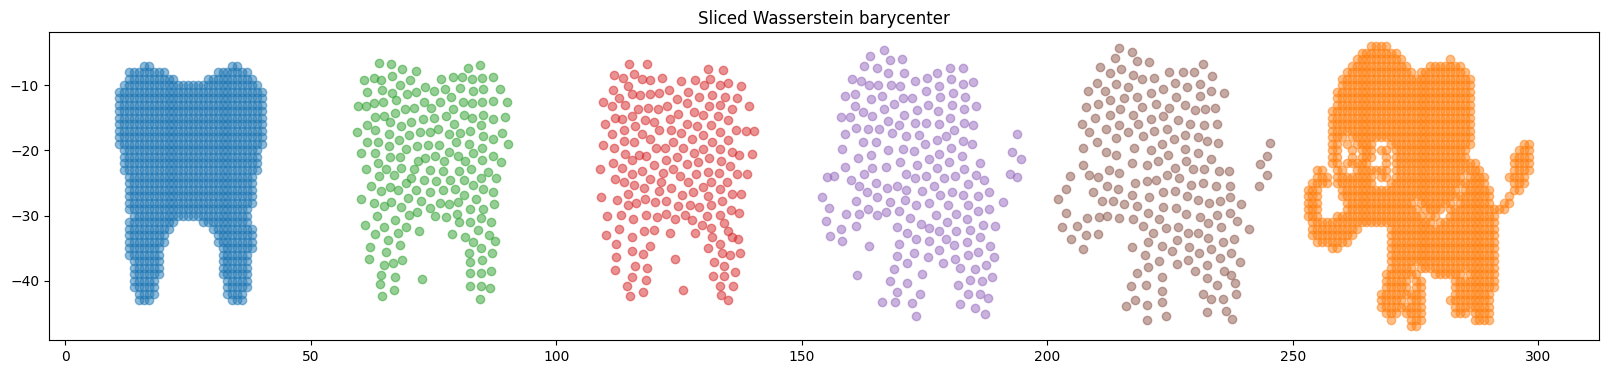

In [39]:
ALPHA = [0.2, 0.4, 0.6, 0.8]
xb = []
for a in ALPHA:
    xb.append(compute_sliced_wass_barycenter(x1, x3, alpha = a))

pl.figure(6, (20, 4))
pl.scatter(x1[:, 0], x1[:, 1], alpha=0.5, label='$\mu$')
pl.scatter(x2[:, 0]+150, x2[:, 1], alpha=0.5, label=r'$\nu$')

for i in range(len(xb)):
    pl.scatter(xb[i][:, 0]+50*(1+i), xb[i][:, 1], alpha=0.5, label='Slices Wasserstein Barycenter')
pl.title('Sliced Wasserstein barycenter')
#pl.legend(loc='upper left')

ax = pl.axis()